In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread as imread

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

In [4]:
# MNIST dataset: 60000 28x28 color images in 10 classes, with 6000 images per class

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
# print("train_dataset", train_dataset)
# print("test_dataset", test_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# print("train_loader", iter(train_loader))
# print("test_loader", iter(test_loader))


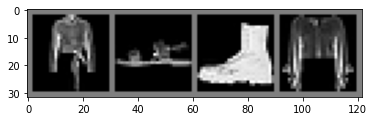

In [5]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

def imshow(img):
#     print("Before un normalise", img)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
#     print("After un normalise", npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# print("images\n", images, "and images shape", images.shape)
# print("labels\n", labels)
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
       # -> n, 1, 28+4, 28+4
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


In [7]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 1, 32, 32] = 4, 3, 1024
        # input_layer: 1 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/5], Step [2000/15000], Loss: 2.2422
Epoch [1/5], Step [4000/15000], Loss: 2.0153
Epoch [1/5], Step [6000/15000], Loss: 1.1606
Epoch [1/5], Step [8000/15000], Loss: 0.6184
Epoch [1/5], Step [10000/15000], Loss: 0.3474
Epoch [1/5], Step [12000/15000], Loss: 0.9112
Epoch [1/5], Step [14000/15000], Loss: 0.2891
Epoch [2/5], Step [2000/15000], Loss: 0.5183
Epoch [2/5], Step [4000/15000], Loss: 0.3179
Epoch [2/5], Step [6000/15000], Loss: 0.3015
Epoch [2/5], Step [8000/15000], Loss: 0.5893
Epoch [2/5], Step [10000/15000], Loss: 0.7359
Epoch [2/5], Step [12000/15000], Loss: 0.9206
Epoch [2/5], Step [14000/15000], Loss: 0.6760
Epoch [3/5], Step [2000/15000], Loss: 0.3333
Epoch [3/5], Step [4000/15000], Loss: 1.9394
Epoch [3/5], Step [6000/15000], Loss: 0.4853
Epoch [3/5], Step [8000/15000], Loss: 0.0378
Epoch [3/5], Step [10000/15000], Loss: 0.4432
Epoch [3/5], Step [12000/15000], Loss: 0.8099
Epoch [3/5], Step [14000/15000], Loss: 0.8516
Epoch [4/5], Step [2000/15000], Loss: 1.7303
E

In [9]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 86.08 %
Accuracy of T-shirt: 83.8 %
Accuracy of Trouser: 96.2 %
Accuracy of Pullover: 81.8 %
Accuracy of Dress: 92.2 %
Accuracy of Coat: 71.1 %
Accuracy of Sandal: 95.8 %
Accuracy of Shirt: 56.5 %
Accuracy of Sneaker: 95.2 %
Accuracy of Bag: 93.8 %
Accuracy of Ankle boot: 94.4 %


In [10]:
PATH = './cnn1.pth'
torch.save(model.state_dict(), PATH)

In [11]:
from joblib import dump, load
dump(model, 'check.joblib') 

c:\users\abhishek pratap\machine learning\pytorch_test\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


['check.joblib']